In [74]:
import galarp as grp

grp.pyplot_style()
cmap = grp.lavender_cmap(step_1=50)

import numpy as np

from astropy import units as u
from astropy import constants as c
from astropy.table import Table

from gala import dynamics as gd
from gala import potential as gp

from gala.units import galactic
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt

from astropy.modeling import models, fitting

import string

from tqdm import tqdm


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$R$ [$\\mathrm{kpc}$]', ylabel='$v_{\\rm circ}$ [$\\mathrm{km\\,s^{-1}}$]'>)

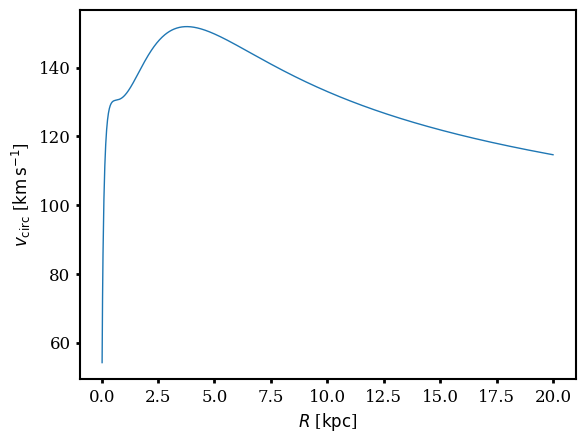

In [2]:
M_halo = 8.6e10 * u.Msun
a_halo = 12 * u.kpc

M_bulge = 5.6e9 * u.Msun
a_bulge = 387 * u.pc

M_disk = 2.6e10 * u.Msun
a_disk = 2.7 * u.kpc
b_disk = 250 * u.pc

halo = gp.NFWPotential(m=M_halo, r_s=a_halo, units=galactic)
bulge = gp.HernquistPotential(m=M_bulge, c=a_bulge, units=galactic)
disk = gp.MiyamotoNagaiPotential(m=M_disk, a=a_disk, b=b_disk, units=galactic)

pot = gp.CCompositePotential()
pot['halo'] = halo
pot['bulge'] = bulge
pot['disk'] = disk


pot.plot_rotation_curve(R_grid=np.linspace(0, 20, 1000) * u.kpc)

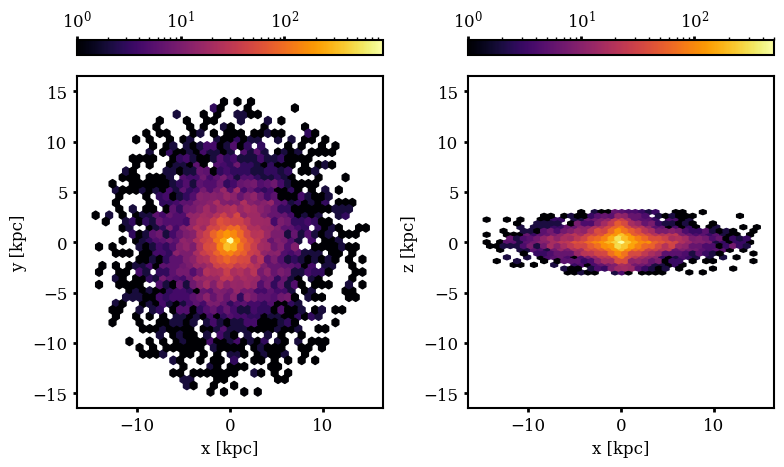

In [80]:
pd = grp.ParticleDistribution.from_file("temp/positions.npy")
pd.plot_positions()
particles = grp.ParticleSet(pd)
particles.generate(grp.gen_mass_profile(pot))

xyz = np.array([pd.x.value, pd.y.value, pd.z.value])

In [5]:
wind = grp.LorentzianWind(t0=500 * u.Myr, width=500 * u.Myr, 
                          strength=800 * u.km / u.s, inclination=np.deg2rad(45), 
                          units=galactic)

sim = grp.RPSim(wind=wind, potential=pot, method=grp.F_RPS_Vollmer)

orbits = sim.run(particles, rho_icm=1e-26 * u.g / u.cm**3, integration_time=1.5 * u.Gyr)

--------------------------------------------------------------------------------
------ Running GALA sim with  8.18e-01 kpc / Myr  wind at  0.79  degrees -------
---- Running for 1.5 Gyr  at a timestep of  5.0 Myr  (0.3 Gyr / Myr steps) -----
--------------------------------------------------------------------------------
---------------------- Container contains 10000 particles ----------------------
- Each cloud has a mass of  1.0e+05 solar masses  and a radius of  50.00 pc   --
------------- This corresponds to a density of 5.41e-23 g / cm3   --------------
--------------------------------------------------------------------------------


100%|██████████| 299/299 [00:03<00:00, 79.65it/s]


In [6]:
grp.animated_hexbin_plot(orbits, outname="figures/vollmer/test_animate.gif")

In [14]:
rho_0 = (1e-4 * u.cm**-3 * c.u).cgs
v_0 = (1000 * u.km / u.s).cgs

P_ram_0 = rho_0 * v_0**2
print(rho_0, P_ram_0)


1.6605390666e-28 g / cm3 1.6605390666e-12 g / (cm s2)


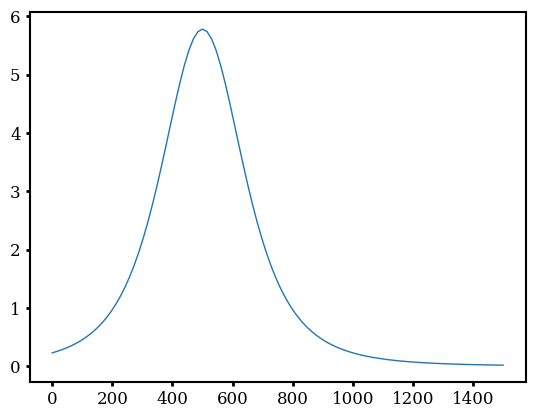

In [54]:
wind = grp.LorentzianWind(t0=500 * u.Myr, width=500 * u.Myr, 
                          strength=800 * u.km / u.s, inclination=np.deg2rad(45), 
                          units=galactic)

density = 1.5e-27 * u.g / u.cm**3

times = np.linspace(0, 1500, 100) * u.Myr
wind_strength = np.sqrt(np.sum(wind.evaluate_arr(times) **2, axis=1)) * u.kpc / u.Myr

p_ram = density * wind_strength.to(u.km / u.s) ** 2 


plt.plot(times, (p_ram / P_ram_0).cgs)

[]

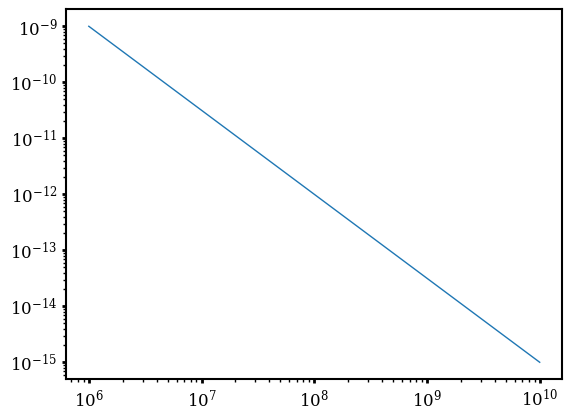

In [57]:
masses = np.logspace(6, 10, 100) * u.Msun

plt.plot(masses, masses ** -1.5)
plt.loglog()


In [68]:
def peak_velocity(zeta, rho_0 = 1e-4 * u.cm**-3 * c.u, v_0 = 1000 * u.km / u.s, rho=1.5e-27 * u.g / u.cm**3):
    return np.sqrt(zeta * rho_0 * v_0 **2 / rho).to(u.km/u.s)


index = 0
runs = []
for theta in [0, 20, 45, 90]:
    for zeta in [10, 20, 50, 100]:
        runs.append({"LABEL": string.ascii_uppercase[index], "ZETA": zeta, "THETA": theta})
        index += 1


{'LABEL': 'A', 'ZETA': 10, 'THETA': 0}
{'LABEL': 'B', 'ZETA': 20, 'THETA': 0}
{'LABEL': 'C', 'ZETA': 50, 'THETA': 0}
{'LABEL': 'D', 'ZETA': 100, 'THETA': 0}
{'LABEL': 'E', 'ZETA': 10, 'THETA': 20}
{'LABEL': 'F', 'ZETA': 20, 'THETA': 20}
{'LABEL': 'G', 'ZETA': 50, 'THETA': 20}
{'LABEL': 'H', 'ZETA': 100, 'THETA': 20}
{'LABEL': 'I', 'ZETA': 10, 'THETA': 45}
{'LABEL': 'J', 'ZETA': 20, 'THETA': 45}
{'LABEL': 'K', 'ZETA': 50, 'THETA': 45}
{'LABEL': 'L', 'ZETA': 100, 'THETA': 45}
{'LABEL': 'M', 'ZETA': 10, 'THETA': 90}
{'LABEL': 'N', 'ZETA': 20, 'THETA': 90}
{'LABEL': 'O', 'ZETA': 50, 'THETA': 90}
{'LABEL': 'P', 'ZETA': 100, 'THETA': 90}


In [78]:
rho_icm = 1e-26 * u.g / u.cm**3

vollmer_results = []

for run in tqdm(runs, desc=f"Running Vollmer Duplicates"):

    peak_v = peak_velocity(run["ZETA"], rho=rho_icm)
    
    wind = grp.LorentzianWind(t0=500 * u.Myr, width=200 * u.Myr,
                              strength=peak_v, inclination=np.deg2rad(90 - run["THETA"]),
                              units=galactic)
    
    sim = grp.RPSim(wind=wind, potential=pot, method=grp.F_RPS_Vollmer)

    orbits = sim.run(particles, rho_icm=1e-26 * u.g / u.cm**3, integration_time=1.5 * u.Gyr, printout=False)

    #grp.animated_hexbin_plot(orbits, outname=f"figures/vollmer/test_animate_RUN_{run['LABEL']}.gif")
    
    vollmer_results.append({"ORBITS":orbits, "WIND": wind, "V_PEAK": peak_v}.update(run))

Running Vollmer Duplicates: 100%|██████████| 16/16 [01:12<00:00,  4.52s/it]


In [89]:
cloud_masses = []


def power_law_pdf(m, alpha):
    return m**(-alpha)

def monte_carlo_power_law(alpha, m_min, m_max, size):
    """
    Sample values from a power-law distribution proportional to m^-alpha using
    rejection sampling (Monte Carlo method).
    
    Parameters:
    - alpha (float): the exponent in the power-law distribution (1.5 in your case)
    - m_min (float): the minimum value of m
    - m_max (float): the maximum value of m
    - size (int): the number of samples to generate
    
    Returns:
    - samples (ndarray): an array of sampled values
    """
    samples = []
    max_pdf = power_law_pdf(m_min, alpha)  # The maximum value of the PDF for normalization
    
    while len(samples) < size:
        # Sample uniformly in the range [m_min, m_max]
        m_candidate = np.random.uniform(m_min, m_max)
        # Sample uniformly in the range [0, max_pdf]
        u = np.random.uniform(0, max_pdf)
        # Accept the sample if u is less than the PDF value at m_candidate
        if u < power_law_pdf(m_candidate, alpha):
            samples.append(m_candidate)
    
    return np.array(samples)


masses = monte_carlo_power_law(1.5, 1e6, 1e10, 1000) * u.Msun



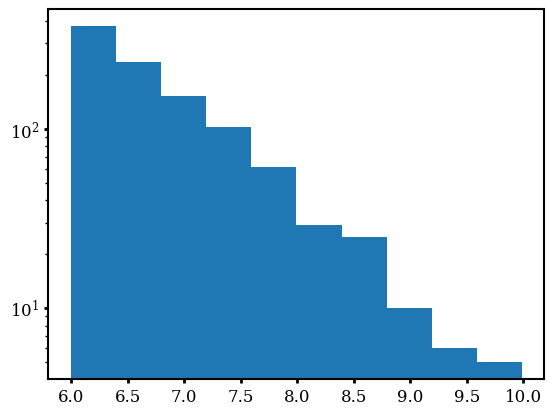

In [90]:
plt.hist(np.log10(masses.value))
plt.yscale("log")

